# Исследование данных сервиса аренды самокатов


***Описание и цели проекта***

Изучим данные сервиса аренды самокатов GoFast о пользователях и поездках, а также проверим несколько гипотез на основании трех датасетов, имеющихся в нашем распоряжении: 

- данные о пользователях: уникальный идентификатор пользователя, имя, возраст, город и тип подписки;
- данные о поездказ: уникальный идентификатор пользователя, расстояние поездки в метрах, длительность поездки в минутах, дата поездки;
- данные о двух возможных типах подписок: тип подписки, стоимость минуты поездки, стоимость начала поездки, стоимость ежемесячного платежа.
    
На основаниии указанных данных с целью определения возможных зон роста для бизнеса выполним следующие задачи:
1. Изучим исходные датафреймы и выполним предобработку для дальнейшего анализа: проверим наличие пропусков, дубликатов и определим типы данных.
2. Проведем исследовательский анализ данных: изучим данные о пользователях и поездках, выявим основные тенденции и характерные особенности, определим, как выглядит среднестатическая поездка и пользователь. 
3. Расммотрим две категории пользователей: с платной подлпиской и без. Опеределим различия в основных параметрах поездок пользователей каждой категории и изучим выручку, которую они приносят помесячно.  
4. Проверим ряд гипотез, которые могут помочь улучшить показатели бизнеса.

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import sqrt
from scipy.stats import binom


## Загрузка данных <a id='download'></a>

In [78]:
# Загрузим данные о пользователях
data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [79]:
# Данные о поездках
data_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
data_rides.info()
data_rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [80]:
# Данные о подписках
data_subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
data_subscriptions.info()
data_subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [81]:
# Сохраним в переменных первоначальное количество строк для контроля объема удаляемых данных в случае необходимости
data_users_rows = data_users.shape[0]
data_rides_rows = data_rides.shape[0]
data_subscriptions_rows = data_subscriptions.shape[0]

Все три датасета не имеют пропусков, типы данных также соответствуют содержащейся в столбцах информации за исключением столбца с датой поездки, отредактируем его на этапе предобработки.

## Предобработка данных <a id='processing'></a>

Проверим данные на наличие пропусков и дубликатов, обработаем их

In [82]:
# Посчитаем количество пропусков в данных о пользователях и количество дубликатов
print(data_users.isna().sum().sort_values(ascending = False))
f'Количество дубликатов {data_users.duplicated().sum()}'

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


'Количество дубликатов 31'

In [83]:
# Удалим дубликаты в данных о пользователях 
data_users = data_users.drop_duplicates().reset_index(drop = True)

# Оценим долю удаленных данных 
1 - data_users.shape[0]/data_users_rows

0.019808306709265144

In [84]:
# Посчитаем количество пропусков в данных о поездках и количество дубликатов
print(data_rides.isna().sum().sort_values(ascending = False))
f'Количество дубликатов {data_rides.duplicated().sum()}'

user_id     0
distance    0
duration    0
date        0
dtype: int64


'Количество дубликатов 0'

In [85]:
# Посчитаем количество пропусков в данных о подписках и количество дубликатов
print(data_subscriptions.isna().sum().sort_values(ascending = False))
f'Количество дубликатов {data_subscriptions.duplicated().sum()}'

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


'Количество дубликатов 0'

In [86]:
# Изменим тип данных в столбце с датой поездки
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')

# Проверим, за какой период предоставлены данные о поездках во избежение агрегации данных за несколько лет
print(data_rides['date'].min())
data_rides['date'].max()

2021-01-01 00:00:00


Timestamp('2021-12-30 00:00:00')

Данные предоставлены за период с 01.01.2021 по 30.12.2021, т.е. они укладываются в один календарный год.

In [87]:
# Создадим новый столбец с номером месяца
data_rides['month_number'] = data_rides['date'].dt.month

# Проверим изменения
data_rides.head()

,user_id,distance,duration,date,month_number
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


## Исследовательский анализ данных<a id='analysis'></a>

In [88]:
# Частота встречаемости городов
data_users_pivot = (data_users
                    .pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
                    .sort_values(by = 'user_id', ascending = False)
                   )
data_users_pivot['Доля от общего числа, %'] = (data_users_pivot['user_id']/data_users.shape[0]).round(4) * 100
data_users_pivot.rename(columns = {'user_id': 'Количество пользователей'}, inplace = True)
data_users_pivot

,Количество пользователей,"Доля от общего числа, %"
city,,
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


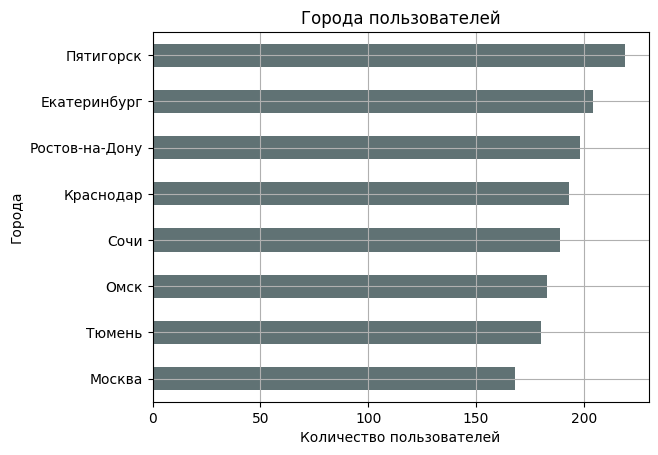

In [89]:
# Визуализируем встречаемость городов
ax = data_users_pivot['Количество пользователей'].sort_values().plot(kind = 'barh', grid = True, color = '#607274')
ax.set_ylabel('Города')
ax.set_xlabel('Количество пользователей')
ax.set_title('Города пользователей')
plt.show()

Наиболее часто в выборке встречаются пользователи из Пятигорска (219 человек - 14,28 % от общего числа) и Екатеринбурга (204 - 13,3 %), реже всего -  из Москвы (168 - 10,95 %). По гисторамме видно, что численность пользователей из разных городов сопоставима, все города - крупные центры, что удобно для сравнения. 

In [90]:
# Соотношение пользователей с подпиской и без подписки
sub_number = data_users['subscription_type'].value_counts()
sub_percent = data_users['subscription_type'].value_counts()/data_users.shape[0]
sub_percent_number = pd.concat([sub_number, sub_percent.round(4)*100], axis = 1, keys=['Количество пользователей', 'Доля от общего числа, %'])
sub_percent_number

,Количество пользователей,"Доля от общего числа, %"
free,835,54.43
ultra,699,45.57


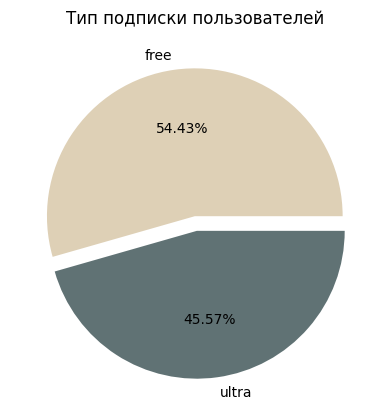

In [91]:
# Визуализируем cоотношение пользователей с подпиской и без подписки
sub = data_users.groupby('subscription_type')['user_id'].count().plot(kind = 'pie', explode = (0, 0.1), autopct = '%1.2f%%', colors = ['#DED0B6', '#607274'])
sub.set_title('Тип подписки пользователей')
sub.set_ylabel('')
plt.show()

Количество пользователей без подписки (54,43 % от общего числа) превышает количество пользователей с платной подпиской (45,57 % от общего числа).  

In [92]:
# Изучим возраст пользователей
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Возраст пользователей')

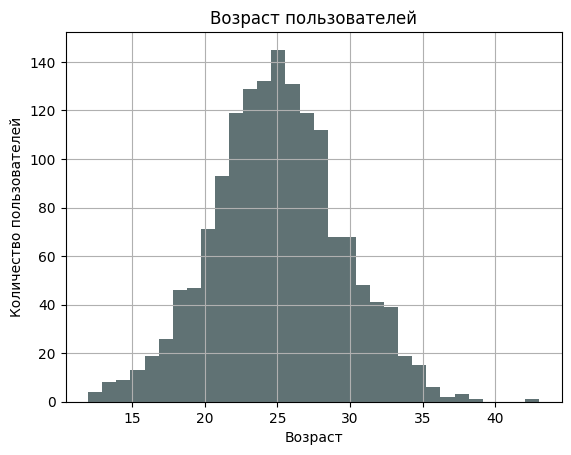

In [93]:
# Визуализируем данные о возрасте пользователей
us = data_users['age'].hist(bins = 32, color = '#607274')
us.set_xlabel('Возраст')
us.set_ylabel('Количество пользователей')
us.set_title('Возраст пользователей')

Возраст всех пользователей - от 12 до 43 лет, при этом наибольшее число пользователей - в возрасте от 20 до 30 лет, средний возраст - 25 лет. Пользователей старше 35 мало, а старше сорока - практически нет. Таким образом, сервис наиболее популярен у молодых людей.

In [94]:
# Изучим расстояние, которое пользователь преодолел за одну поездку
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0.5, 1.0, 'Расстояние за одну поездку')

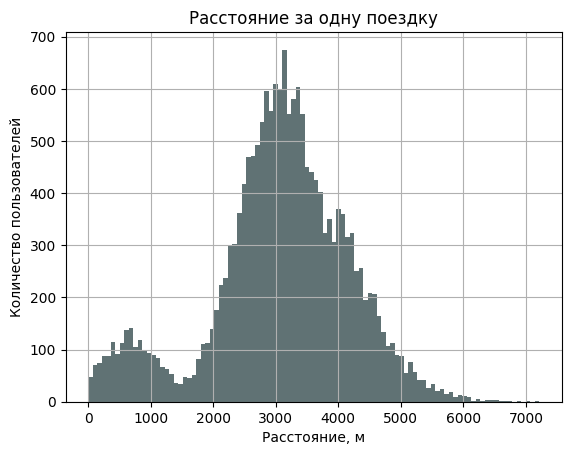

In [95]:
# Визуализируем расстояние, которое пользователь преодолел за одну поездку
rid = data_rides['distance'].hist(bins = 100, color = '#607274')
rid.set_xlabel('Расстояние, м')
rid.set_ylabel('Количество пользователей')
rid.set_title('Расстояние за одну поездку')

In [96]:
data_rides.query('distance < 100').shape[0]

78

Расстояния, которое преодолевали пользователи за одну поездку - от 0,8 метров до 7,2 км. При этом присутствуют подозрительно короткие поездки: например, 78 поездок имели длину менее 100 метров. Поездки на длинные дистанции свыше 6 км встречаются редко.
Среднее расстояние, которое совершает пользователь во время поездки - 3 км. На гистограмме виден резкий спад количества поездок на отметке примерно в 1,5 км, возможно, поездки до указанной отметки имеют отдельную природу, например, отмененные по причине технической неисправности самоката или проблем с приложением. 

In [97]:
# Изучим продолжительность поездок
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

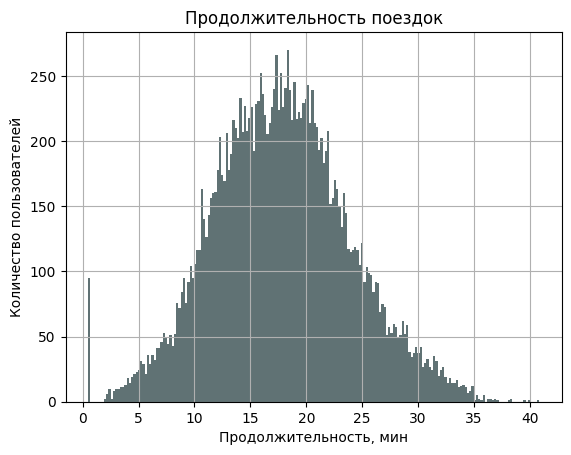

In [98]:
# Визуализируем продолжительность поездок
dur = data_rides['duration'].hist(bins = 200, color = '#607274')
dur.set_xlabel('Продолжительность, мин')
dur.set_ylabel('Количество пользователей')
dur.set_title('Продолжительность поездок')
plt.show()

Длительность поездок составила от 0.5 до 40.8 минут, средняя продолжительность поездки - 17 минут. Длинные поездки свыше 35 минут встречаются редко. Кроме того, на гистограмме видим всплеск на отметке 0,5 минуты - 95 поездок имеют такую длительность, вероятно, имел место какой-то технический сбой, понять природу которого важно, т.к. длительность поездки напрямую влияет на стоимость и, соответственно, на выручку.

## Объединение данных<a id='visualize'></a>

In [99]:
# Объединим данные о пользователях, поездках и подписках в один датафрейм
data = data_rides.merge(data_users, on = 'user_id', how = 'left')
data = data.merge(data_subscriptions, on = 'subscription_type', how = 'left')
data.head(10)

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [100]:
# Проверим размер датафрейма после объединения
data.shape

(18068, 12)

In [101]:
# Проверим объединенный датафрейм на пропуски
data.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month_number         0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В объединенном датасете пропуски отсутвуют, количество строк соответсвует количеству строк в данных о поездках.

In [102]:
# Создадим два датафрейма с данными о пользователях с подпиской и без
data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')

In [103]:
# Оценим долю поездок совершенных пользователями с подпиской и без
data_sub_number = data['subscription_type'].value_counts()
data_sub_percent = data['subscription_type'].value_counts()/data.shape[0]
data_sub_percent_number = pd.concat([data_sub_number, data_sub_percent.round(4)*100], axis = 1, keys=['Количество поездок', 'Доля от общего числа, %'])
data_sub_percent_number

,Количество поездок,"Доля от общего числа, %"
free,11568,64.02
ultra,6500,35.98


Большая часть рассматриваемых поездок (63,8 %) совершена пользователями без подписки.

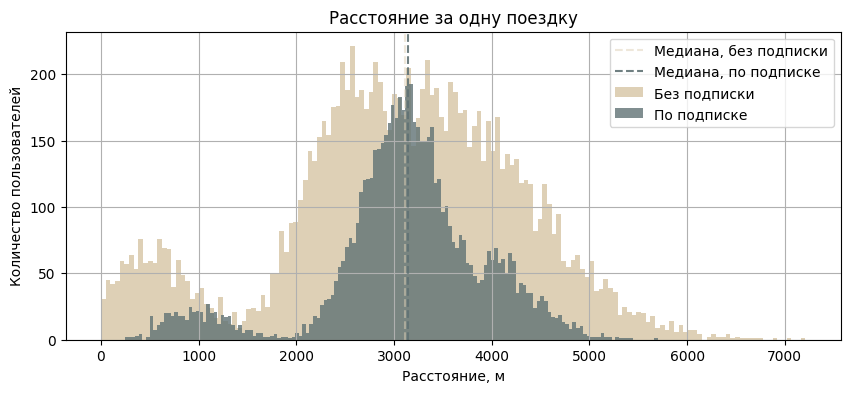

In [104]:
# Визуализируем информацию о расстоянии для пользователей обеих категорий
ultra_dist_median = data_ultra['distance'].median()

free_dist_median = data_free['distance'].median()

data_free_hist = data_free['distance'].hist(bins = 150, label = 'Без подписки', color = '#DED0B6')
data_free_hist.axvline(free_dist_median, label = 'Медиана, без подписки', color = '#DED0B6', alpha = 0.5, linestyle = '--')

data_ultra_hist = data_ultra['distance'].hist(bins = 150, ax = data_free_hist, figsize = (10, 4), alpha = 0.8, label = 'По подписке', color= '#607274')
data_ultra_hist.axvline(ultra_dist_median, label = 'Медиана, по подписке', color = '#607274', alpha = 0.9, linestyle = '--')
data_ultra_hist.set_xlabel('Расстояние, м')
data_ultra_hist.set_ylabel('Количество пользователей')
data_ultra_hist.set_title('Расстояние за одну поездку')
plt.legend()
plt.show()

Пользователи без подписки чаще совершают поездки, при этом разброс преодолеваемого расстояния у них шире, а медианное расстояние немного меньше, чем у пользователей с подпиской и составляет чуть больше 3 км.

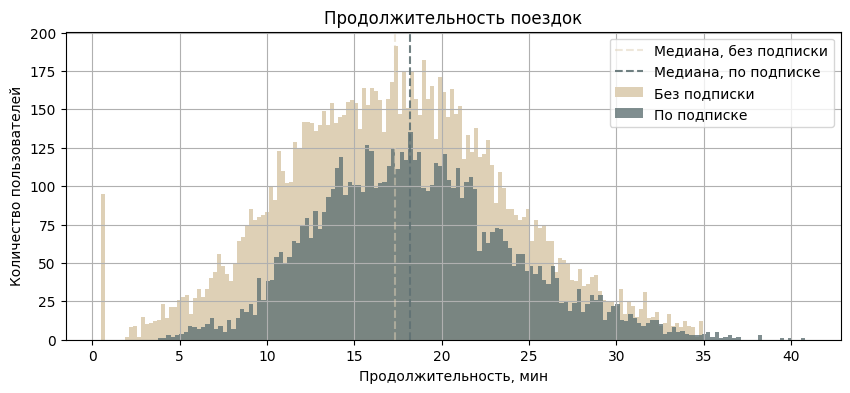

In [105]:
# Визуализируем информацию о расстоянии поездок для пользователей обеих категорий
ultra_dur_median = data_ultra['duration'].median()

free_dur_median = data_free['duration'].median()

data_free_hist_dur = data_free['duration'].hist(bins = 150, label = 'Без подписки', color = '#DED0B6')
data_free_hist_dur.axvline(free_dur_median, label = 'Медиана, без подписки', color = '#DED0B6', alpha = 0.5, linestyle = '--')

data_ultra_hist_dur = data_ultra['duration'].hist(bins = 150, ax = data_free_hist_dur, figsize = (10, 4), alpha = 0.8, label = 'По подписке', color = '#607274')
data_ultra_hist_dur.axvline(ultra_dur_median, label = 'Медиана, по подписке', color = '#607274', alpha = 0.9, linestyle = '--')
data_ultra_hist_dur.set_xlabel('Продолжительность, мин')
data_ultra_hist_dur.set_ylabel('Количество пользователей')
data_ultra_hist_dur.set_title('Продолжительность поездок')
plt.legend()
plt.show()

Пользователи без подписки чаще совершают поездки, однако медианное время поездки у них меньше, чем у пользователей с подпиской.

## Подсчёт выручки<a id='earnings'></a>

In [106]:
# Округлим в большую сторону длительность поездки, т.к. оплата поминутная
data['duration'] = np.ceil(data['duration']) 

# Создадим датафрейм с агрегированными данными о поездках: 
# суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, 
# а также данные о подписке для подсчета выручки
data_grouped = (data
                .groupby(['user_id', 'month_number'])
                .agg({'distance': 'sum', 'duration': 'sum', 'date': 'count', 'subscription_type': 'first'})
                .reset_index()
                .rename(columns = {'date': 'rides_number'})
                .merge(data_subscriptions, on = 'subscription_type', how = 'left')
               )

data_grouped.head(10)

,user_id,month_number,distance,duration,rides_number,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199
5,1,12,6751.629942,28.0,2,ultra,6,0,199
6,2,3,10187.723006,63.0,3,ultra,6,0,199
7,2,4,6164.381824,40.0,2,ultra,6,0,199
8,2,6,3255.338202,14.0,1,ultra,6,0,199
9,2,7,6780.722964,48.0,2,ultra,6,0,199


In [107]:
# Проверим сводную таблицу на пропуски
data_grouped.isna().sum()

user_id              0
month_number         0
distance             0
duration             0
rides_number         0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В сводной таблице пропуски отсутствуют

In [108]:
# Добавим столбец с помесячной выручкой, которую принёс каждый пользователь за каждый месяц

data_grouped['earnings'] = data_grouped['subscription_fee'] + data_grouped['start_ride_price']*data_grouped['rides_number'] + data_grouped['minute_price']*data_grouped['duration']

data_grouped.head(10)

,user_id,month_number,distance,duration,rides_number,subscription_type,minute_price,start_ride_price,subscription_fee,earnings
0,1,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,4,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,8,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,10,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,11,7003.499363,56.0,3,ultra,6,0,199,535.0
5,1,12,6751.629942,28.0,2,ultra,6,0,199,367.0
6,2,3,10187.723006,63.0,3,ultra,6,0,199,577.0
7,2,4,6164.381824,40.0,2,ultra,6,0,199,439.0
8,2,6,3255.338202,14.0,1,ultra,6,0,199,283.0
9,2,7,6780.722964,48.0,2,ultra,6,0,199,487.0


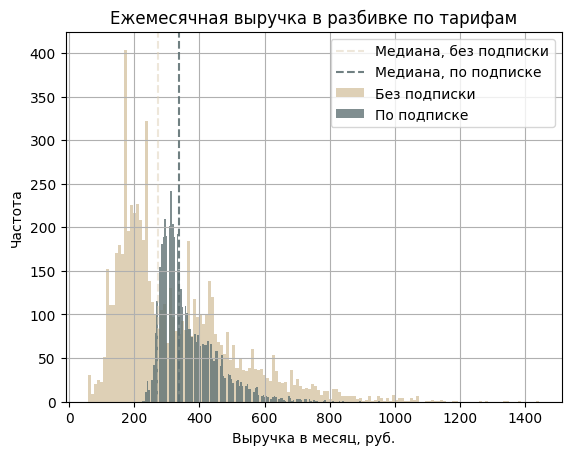

In [109]:
#Исследуем ежемесячную выручку пользователей с платной полпиской и без нее и построим распределения  

data_grouped_ultra = data_grouped.query('subscription_type == "ultra"')
data_grouped_free = data_grouped.query('subscription_type == "free"')

data_grouped_ultra_median = data_grouped_ultra['earnings'].median()
data_grouped_free_median = data_grouped_free['earnings'].median()


data_grouped_free_hist = data_grouped_free['earnings'].hist(bins = 150, label = 'Без подписки', color = '#DED0B6') 
data_grouped_free_hist.axvline(data_grouped_free_median, label = 'Медиана, без подписки', color = '#DED0B6', alpha = 0.5, linestyle = '--')

data_grouped_ultra_hist = data_grouped_ultra['earnings'].hist(bins = 150, label = 'По подписке', alpha = 0.8, ax = data_grouped_free_hist, color = '#607274')
data_grouped_ultra_hist.axvline(data_grouped_ultra_median, label = 'Медиана, по подписке', color = '#607274', alpha = 0.9, linestyle = '--')
                                                             
data_grouped_ultra_hist.set_xlabel('Выручка в месяц, руб.')
data_grouped_ultra_hist.set_ylabel('Частота')
data_grouped_ultra_hist.set_title('Ежемесячная выручка в разбивке по тарифам')
plt.legend()
    
plt.show()


Согласно гистограмме ежемесячная выручка пользователей с платной подпподпиской имеет меньший разрос и смещена вправо, в сторону увеличения выручки, кроме того медианное значение ежемесячной выручки пользователей с подпиской выше, чем пользователей без нее.

## Проверка гипотез<a id='hypotheses'></a>

**Проверим гипотезу:** тратят ли пользователи с подпиской больше времени на поездки? Это важно, т.к. длительность поездки напрямую влияет на выручку. Для этого:
    
   1. Сформулируем нулевую гипотезу: пользователи с платной подпиской в среднем тратят на поездки столько же времени, сколько пользователи без подписки.
   2. Сформулируем альтернативную гипотезу: пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки.

In [110]:
# На шаге 4 мы видели, что продолжительность поездок для пользователей с подпиской и без распределена нормально.
# Проверим с помощью t-теста гипотезу о том, тратят ли пользователи с подпиской больше времени на поездки
# Вычислим среднее по каждой выборке

ultra_dur_mean = data_ultra['duration'].mean().round(2)
free_dur_mean = data_free['duration'].mean().round(2)

print(f'Средняя продолжительность поездки пользователя с подпиской равна {ultra_dur_mean} минут.')
print(f'Средняя продолжительность поездки пользователя без подписки равна {free_dur_mean} минут.')

# проводим t-test для двух независимых выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
# зададим уровень значимости

alpha = 0.05
results_dur = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater', equal_var = False)

print(f'p-value: {results_dur.pvalue}')

# проверяем p-value
if results_dur.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя продолжительность поездки пользователя с подпиской равна 18.54 минут.
Средняя продолжительность поездки пользователя без подписки равна 17.39 минут.
p-value: 5.675781377128977e-37
Отвергаем нулевую гипотезу


Полученное значение p-value (1.6162210195310587e-29) намного меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу в пользу альтернативной - пользователи с подпиской в среднем тратят больше времени на поездку, а значит потенциально более выгодны с точки зрения потенциальной выручки за поездки.

**Проверим гипотезу:** можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (оптимальное с точки зрения износа самоката). Для этого:
    
   1. Сформулируем нулевую гипотезу: пользователи с платной подпиской в среднем за одну поездку проезжают 3130 метров.
   2. Сформулируем альтернативную гипотезу: пользователи с подпиской в среднем за одну поездку проезжают больше 3130 метров.

In [111]:
# Проверим гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, 
# не превышает 3130 метров — оптимальное с точки зрения износа самоката.

ultra_dis_mean = data_ultra['distance'].mean().round(2) 
print(f'Среднее расстояние, которое проезжают пользователи с подпиской равно {ultra_dis_mean} метров.')

# проводим одновыборочный t-test, в качестве альтернативной используем одностороннюю гипотезу «меньше»
# зададим уровень значимости

alpha = 0.05
value = 3130
results_dis = st.ttest_1samp(data_ultra['distance'], value, alternative = 'greater')

print('p-value:', results_dis.pvalue)

# проверяем p-value
if (results_dis.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

Среднее расстояние, которое проезжают пользователи с подпиской равно 3115.45 метров.
p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


Полученное значение p-value позволяет не отвергать нулевую гипотезу о том, что пользователи с подпиской проезжают в среднем не более 3130 метров, то есть преодолевают расстояние оптимальное с точки зрения износа самоката.

***Проверим гипотезу:*** будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Для этого:
    
   1. Сформулируем нулевую гипотезу: помесячная выручка от пользователей с подпиской по месяцам равна выручке пользователей без подписки.
   2. Сформулируем альтернативную гипотезу: помесячная выручка от пользователей с подпиской по месяцам больше выручки пользователей без подписки.

In [112]:
# Посчитаем среднее
data_grouped_ultra_mean = data_grouped_ultra['earnings'].mean().round(2)
data_grouped_free_mean = data_grouped_free['earnings'].mean().round(2)

print(f'Среднемесячная выручка от пользователя с подпиской равна {data_grouped_ultra_mean} рублей.')
print(f'Среднемесячная выручка от пользователя без подписки равна {data_grouped_free_mean} рублей.')

# проводим t-test для двух независимых выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
# зададим уровень значимости

alpha = 0.05
results_earn = st.ttest_ind(data_grouped_ultra['earnings'], data_grouped_free['earnings'], alternative = 'greater', equal_var = False)

print(f'p-value: {results_earn.pvalue}')

# проверяем p-value
if results_earn.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднемесячная выручка от пользователя с подпиской равна 362.79 рублей.
Среднемесячная выручка от пользователя без подписки равна 328.64 рублей.
p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Полученное значение p-value (8.874140893976874e-40) намного меньше заданного уровня значимости, поэтому мы можем отвергнуть нулевую гипотезу в пользу альтернативной - среднемесячная выручка, которую приносит один пользователь с подпиской больше среднемесячной выручки пользователя без нее, что подтверждается гистограммой, построенной на шаге 5.

## Распределения. Задачи <a id='tasks'></a>

**Задача 1.**<p> Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

0.0505235199072141

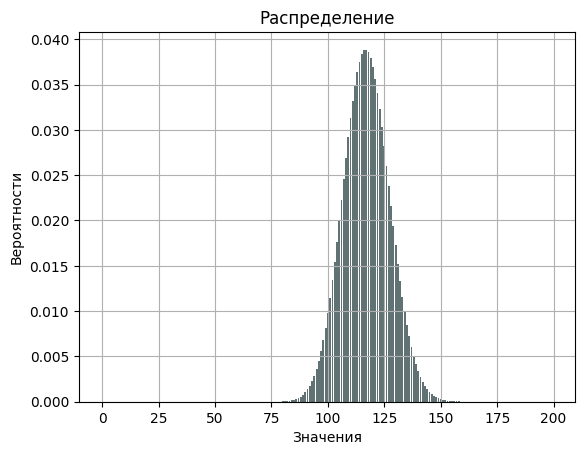

In [113]:
# задаём параметры биномиального распределения для, например, 1000 независимых экспериментов, строим график распределения
# и далее, меняя значение n смотрим, как меняется значение переменной result, 
# в конечном итоге ее значение должно быть максимально близко к 5  
n_sub = 1171
p_sub = 0.1

dr = []

for k in range(0, 200):
    dr.append(binom.pmf(k,n_sub, p_sub))

plt.bar(range(0, 200), dr, color = '#607274')
plt.xlabel('Значения')
plt.ylabel('Вероятности')
plt.title('Распределение')
plt.grid(True)

result = binom.cdf(100,n_sub, p_sub, loc = 0)
result


Таким образом, мы подобрали такое значение количества промокодов n = 1171, при котором вероятность того, что менее 100 чел. продлят подписку, равна 5,05 %.

**Задача 2.** <p> Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

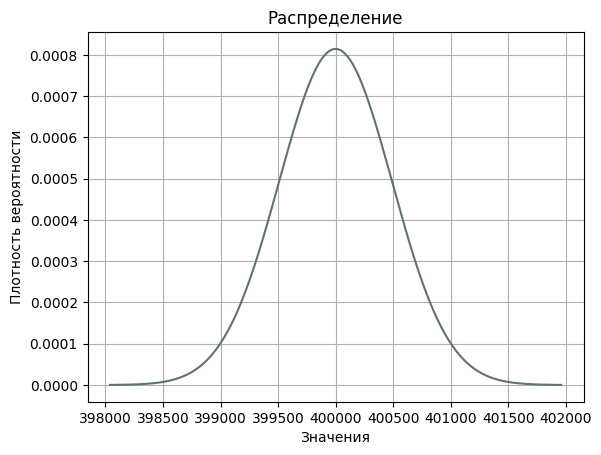

0.15371708296369768


In [114]:
# задаём параметры биномиального распределения
n_push = 1000000
p_push = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n_push * p_push
sigma = sqrt(n_push * p_push * (1 - p_push))

# зададим нормальное распределение
distr = st.norm(mu, sigma)

# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить график 
right = int(mu + 4 * sigma)
left = int(mu - 4 * sigma)

#рисуем график
x = linspace(left, right, 1000)
theplot = plt.subplot()
theplot.plot(x, st.norm.pdf(x, mu, sigma), color = '#607274')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.title('Распределение')
plt.grid(True)
plt.show()


# считаем вероятность хвоста слева от 399500 
result = distr.cdf(399500)
print(result)


Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составило 15,3 %

***Вывод***
<p>Согласно приведенным данным сервиса аренды самокатов о пользователях и поездках больше всего зарегистрированных пользователей в Пятигорске (219 - 14,28 %) и Екатеринбурге (204 - 13,3 %). Средний возраст пользователя сервиса - 25 лет, наиболее популярен сервис у молодых людей в возрасте от 20 до 30 лет, среднее время одной поездки составляет 17 минут, а среднее расстояние - 3 км. 
45,57 % всех пользователей имеют подписку, а 54,43 % пользователей - нет, однако большая часть рассматриваемых поездок (63,8 %) совершена пользователями без подписки, тем не менее анализ параметров поездок пользователей обоих категорий полказал, что пользователи с платной подпиской совершают более длительные по времени и расстоянию поездки, что в свою очередь приводит к тому, что ежемесячная выручка, которую получает сервис от пользователя с подпиской превышает выручку от пользователя без подписки, что делает увеличение количества пользователей с платной подпиской перспективным для роста выручки направлением, так, например, расслыка  1171 промокодов с вероятностью 95% увеличит количество платных подписок минимум на 100 шт.